<a href="https://colab.research.google.com/github/tamojeetroychowdhury/Facial-Expression-Recognition/blob/main/Week-1/Logistic_Regression_Gaia_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Loading Data**

Being the astro enthusiast I am, I'll do a logistic regression with stellar data and their subsequent classification into main-sequence stars or white dwarfs. You can safely skip to the Logistic Regression heading if the data-gathering does not interest you :)

#### **Astroquery and Gaia**
Gaia is a spacecraft by ESA that collects data of stars. I did my Krittika Summer Project on this, visit the associated [GitHub repo](https://github.com/tamojeetroychowdhury/Gaia-Data-Analysis) or feel free to view [the full report](https://drive.google.com/file/d/12HYjZoBuefqs_m41ELJYlqvVdxtMCDGP/view?usp=sharing) for more details.

Gaia data is accessible through a Python module called astroquery, in a format very similar to SQL queries.

In [1]:
!pip install astroquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 6.5 MB/s 
     |████████████████████████████████| 885 kB 61.6 MB/s 
     |████████████████████████████████| 48 kB 5.2 MB/s 
     |████████████████████████████████| 4.0 MB 47.6 MB/s 


In [2]:
import astropy.units as u
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#### **Obtaining Data and Visualizing it**

The cell below collects the requisite data for 10,000 nearest stars (details are unnecessary). In this case here, we can judge a star's age and stage in evolution roughly by looking at its $R$ and $B$ band magnitudes and its absolute magnitude. 

The plot uses precisely those parameters, and splits the stars into two distinct groups - a main diagonal line which is of the main sequence stars, and a lower small diagonal line which has white dwarfs. For what and how it works look up [what are HR diagrams](https://en.wikipedia.org/wiki/Hertzsprung%E2%80%93Russell_diagram) and [how Gaia's data can generate them](https://sci.esa.int/web/gaia/-/60198-gaia-hertzsprung-russell-diagram).

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


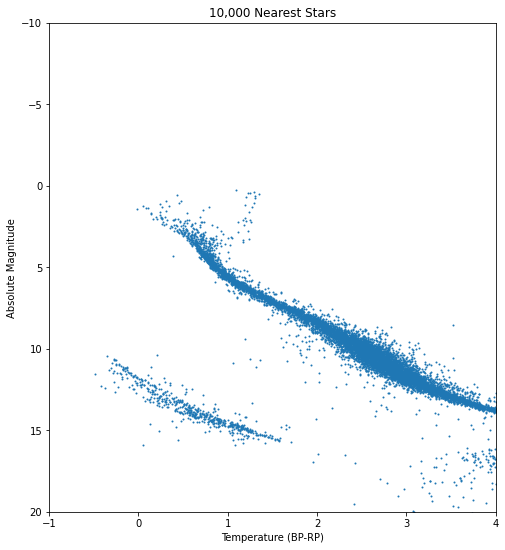

In [3]:
#Nearest 10000 stars
query = '''select top 10000 g.source_id, g.parallax, g.phot_g_mean_mag, g.phot_bp_mean_mag, phot_rp_mean_mag, 
h.classprob_dsc_combmod_star as star_prob, h.classprob_dsc_combmod_whitedwarf as wd_prob
from gaiadr3.gaia_source as g, gaiadr3.astrophysical_parameters as h 
where g.source_id = h.source_id 
and g.source_id is not null and g.parallax is not null and g.phot_g_mean_mag is not null and g.phot_bp_mean_mag is not null
and g.phot_rp_mean_mag is not null
and h.classprob_dsc_combmod_star is not null
and h.classprob_dsc_combmod_whitedwarf is not null
and g.parallax > 10
and g.parallax_over_error > 100
order by g.parallax desc'''

job = Gaia.launch_job_async(query)
r = job.get_results()

appmags = r['phot_g_mean_mag']
dist = 1000*np.reciprocal(r['parallax'])

abmags = appmags + 5 - 5*np.log10(dist)
g = r['phot_bp_mean_mag'] - r['phot_rp_mean_mag']


plt.figure(figsize=(8,9))
plt.scatter(g,abmags,s=1)
plt.ylim(-10,20)
plt.xlim(-1,4)
plt.gca().invert_yaxis()
plt.xlabel('Temperature (BP-RP)')
plt.ylabel('Absolute Magnitude')
plt.title('10,000 Nearest Stars')
plt.show()

In [4]:
len(r)

10000

## **Logistic Regression**

Our final data must have 3 input columns - absolute magnitude, $R$ band magnitude and $B$ band magnitude, and an output column with a $0$ or $1$ signifying that the candidate is a main sequence star or white dwarf respectively. Gaia gives us probability of each candidate being a star or white dwarf, we use those to assign $0$ or $1$.

In [5]:
X = []
y = []
for i in range(len(r)):
  X.append([abmags[i],r['phot_rp_mean_mag'][i],r['phot_bp_mean_mag'][i]])
  if r['star_prob'][i] > r['wd_prob'][i]:
    y.append(0)
  else:
    y.append(1)
X = np.array(X)
y = np.array(y)

Let's also check the number of stars and white dwarfs in the sample. It won't do to have very very few of one kind.

In [15]:
print(f'Number of stars = {list(y).count(0)}; Number of white dwarfs = {list(y).count(1)}')

Number of stars = 9691; Number of white dwarfs = 309


The numbers seem fair. We run the cell below to perform logistic regression and check the outputs. The accuracy is $0.9685$, which is a $96.85\%$ accuracy in the model's predicted values and actual values in the test data.

In [11]:
# 0) Prepare data

n_samples, n_features = X.shape
#n_samples, n_features = 5000,3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

# 1) Model
# Linear model f = wx + b , sigmoid at the end
class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = Model(n_features)

# 2) Loss and optimizer
num_epochs = 100
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 3) Training loop
for epoch in range(num_epochs):
    # Forward pass and loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')


with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy: {acc.item():.4f}')

epoch: 10, loss = 0.5679
epoch: 20, loss = 0.5516
epoch: 30, loss = 0.5361
epoch: 40, loss = 0.5215
epoch: 50, loss = 0.5076
epoch: 60, loss = 0.4944
epoch: 70, loss = 0.4819
epoch: 80, loss = 0.4700
epoch: 90, loss = 0.4586
epoch: 100, loss = 0.4478
accuracy: 0.9685


### **Check for Stochastic Errors**

We know however that the accuracy largely depends on which sample points are used to find the gradient, so essentially random. We thus run the training and accuracy test 20 times using a loop to check if our first run's $0.9685$ accuracy was by fluke or reliable.

In [14]:
# 0) Prepare data

n_samples, n_features = X.shape
#n_samples, n_features = 5000,3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

# 1) Model
# Linear model f = wx + b , sigmoid at the end
class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

for j in range(20):

  model = Model(n_features)
  num_epochs = 100
  learning_rate = 0.01
  criterion = nn.BCELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  for epoch in range(num_epochs):
      y_pred = model(X_train)
      loss = criterion(y_pred, y_train)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

  with torch.no_grad():
      y_predicted = model(X_test)
      y_predicted_cls = y_predicted.round()
      acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
      print(f'accuracy: {acc.item():.4f}')

accuracy: 0.9685
accuracy: 0.9530
accuracy: 0.9345
accuracy: 0.9685
accuracy: 0.9685
accuracy: 0.6090
accuracy: 0.9355
accuracy: 0.9685
accuracy: 0.8935
accuracy: 0.9685
accuracy: 0.9685
accuracy: 0.8715
accuracy: 0.4685
accuracy: 0.9685
accuracy: 0.9685
accuracy: 0.9685
accuracy: 0.9540
accuracy: 0.9685
accuracy: 0.9670
accuracy: 0.8105


We see out of 20 runs, only 5 have accuracy of less than $0.9$ and only 2 of those have less than $0.8$ accuracy. Thus it seems a fair modelling. 